# 从评论文本预测Yelp评分

In [1]:
import pandas as pd
import numpy as np
import json
import sys
sys.path.append('..')

In [2]:
from src import *

business_df = pd.read_json('../data/Yelp Dataset/yelp_academic_dataset_business.json', lines=True)
review_df = pd.read_json('../data/Yelp Dataset/yelp_academic_dataset_review.json', lines=True)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
PingFang = FontProperties(fname='../assets/PingFang.ttc')
plt.style.use('ggplot')

In [ ]:
color_code = '#E5E5E5'
palette_key = 'Twisted Spot Palette'

try:
    with open('../assets/Palette.json', 'r') as file:
        data = json.load(file)
    if color_code in data:
        main_color = data[color_code].get(palette_key, [])
        print("主色调：", main_color)
except FileNotFoundError:
    ImportError("JSON文件格式不正确。")
except json.JSONDecodeError:
    ImportError("JSON文件格式不正确。")

In [ ]:
# 筛选出所有属于"Restaurant"类别的商家
restaurants = business_df[business_df['categories'].str.contains(
    'Restaurant') == True]

# 筛选出那些其 business_id 存在于上面筛选出的商家ID列表中的评论
restaurant_reviews = review_df[review_df.business_id.isin(
    restaurants['business_id']) == True]

print(f"restaurant_reviews 数据框的维度：{restaurant_reviews.shape}")

## 第一部分：采用朴素贝叶斯方法来进行预测

In [6]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [10]:
# 计算训练集大小，取整个数据集的70%
train_size = int(len(restaurant_reviews) * 0.7)

# 将前70%的数据分配给训练集
train = restaurant_reviews[:train_size]

# 将剩余的30%的数据分配给测试集
test = restaurant_reviews[train_size:]

print(f"训练数据集维度： {train.shape}")
print(f"测试数据集维度： {test.shape}")

训练数据集维度： (3307278, 9)
测试数据集维度： (1417406, 9)


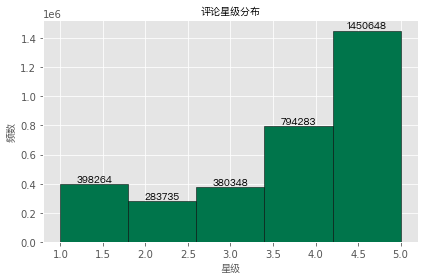

In [13]:
# 筛选出需要的列
train = train[['text', 'stars']]

train_counts, train_bins, train_patches = plt.hist(
    train['stars'], bins=5, color=main_color[0], edgecolor='black')

# 在柱子上方添加数值标签
for count, patch in zip(train_counts, train_patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    plt.text(x, y, str(int(count)), ha='center',
             va='bottom', fontproperties=PingFang)

# 添加图形标题和坐标轴标签
plt.title('评论星级分布', fontproperties=PingFang)
plt.xlabel('星级', fontproperties=PingFang)
plt.ylabel('频数', fontproperties=PingFang)

plt.tight_layout()
plt.savefig('../images/05_评论星级分布.png', dpi=600)
plt.show()

将 `stars` 列独热编码，为列中的每个唯一值创建一个新的列，如果该行在原始列中对应的值为该值，则新列为1，否则为0

In [ ]:
train = pd.get_dummies(train, columns=['stars'])
train.head()

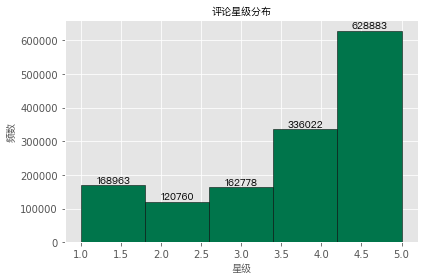

In [15]:
test_counts, test_bins, test_patches = plt.hist(
    test['stars'], bins=5, color=main_color[0], edgecolor='black')

# 在柱子上方添加数值标签
for count, patch in zip(test_counts, test_patches):
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    plt.text(x, y, str(int(count)), ha='center',
             va='bottom', fontproperties=PingFang)

# 添加图形标题和坐标轴标签
plt.title('评论星级分布', fontproperties=PingFang)
plt.xlabel('星级', fontproperties=PingFang)
plt.ylabel('频数', fontproperties=PingFang)

plt.tight_layout()
plt.savefig('../images/05_测试集评论星级分布.png', dpi=600)
plt.show()

In [ ]:
# 筛选出需要的列
test = test[['text', 'stars']]
test = pd.get_dummies(test, columns=['stars'])

In [12]:
print(f"现在训练数据集维度： {train.shape}")
print(f"现在测试数据集维度： {test.shape}")

现在训练数据集维度： (3307278, 13)
现在测试数据集维度： (1417406, 13)


我们使用朴素贝叶斯线性分类器和`TfidfVectorizer`，将评论文本转换为`TF-IDF`加权的词向量，为NLP问题建立一个基线模型。

> 通过比较词在不同星级评论中的出现频率，计算条件概率，从而预测评论的星级。

In [17]:
# 设置TfidfVectorizer，限制最多使用2000个最重要的特征（单词），以构建词向量模型。
max_features = 2000
tfidf = TfidfVectorizer(max_features = max_features)

应用朴素贝叶斯模型，计算给定词汇（如"这", "餐厅", "很", "糟糕"）在不同星级评论下的条件概率，并通过拉普拉斯平滑处理未见过的单词。

> 使用得到的朴素贝叶斯概率作为特征，结合逻辑回归模型来预测评论的星级，从而提高模型的预测精度和解释性。

In [18]:
# 使用sklearn pipeline创建管道：
# 首先使用TfidfVectorizer（tfidf）将文本转换为TF-IDF特征。
# 然后，利用朴素贝叶斯特征转换器（NBFeatures）计算概率特征。
# 最后，将这些特征用于逻辑回归模型（LogisticRegression）进行最终的分类。

lr = LogisticRegression(max_iter=1000) # 初始化逻辑回归模型
nb = NBFeatures(1)  # 初始化朴素贝叶斯特征转换器，参数1可能表示使用拉普拉斯平滑
pl = Pipeline([
    ('tfidf', tfidf),  # 第一步：TF-IDF向量化
    ('nb', nb),        # 第二步：计算朴素贝叶斯概率特征
    ('lr', lr)         # 第三步：逻辑回归分类
])

由于原始星级评分包含多个类别（1星到5星），以下代码将这些评分转换成多个二分类问题，也就是对每个类别（星级），分别预测评论属于该星级的概率。

In [19]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
scores = []  # 存储每个类别的交叉验证分数
preds = np.zeros((len(test), len(class_names)))  # 初始化一个用于存储预济结果的数组

# 遍历每个星级类别，对每个类别进行模型训练和预测
for _, class_name in enumerate(class_names):
    train_target = train[class_name]  # 获取当前星级类别的目标值

    # 计算当前类别的交叉验证分数
    cv_score = np.mean(cross_val_score(estimator=pl,
                                       X=train['text'].values,
                                       y=train_target,
                                       cv=3,
                                       scoring='accuracy'))

    scores.append(cv_score)  # 添加当前星级的分数到列表

    print('类别的CV评分 {} 是 {}'.format(class_name, cv_score))  # 打印当前星级的交叉验证分数

    pl.fit(train['text'].values, train_target)  # 使用当前类别的数据训练模型
    preds[:, _] = pl.predict_proba(test['text'].values)[
        :, 1]  # 对测试集进行概率预测并存储结果

类别的CV评分 stars_1 是 0.9385818186436096
类别的CV评分 stars_2 是 0.9127007164199683
类别的CV评分 stars_3 是 0.8885566922405675
类别的CV评分 stars_4 是 0.7751422771233626
类别的CV评分 stars_5 是 0.8210960796159258


我们使用 sklearn 的 classification_report 生成分类模型的性能报告<br>

`y_true`: 真实的标签，通过从 test_sample 数据集的 class_names 列中取最大值的索引获得<br>

`y_pred`: 预测的标签，通过从预测结果 preds 中取最大值的索引获得

In [20]:
NBF_report = metrics.classification_report(
    y_true=np.argmax(test[class_names].values, axis=1),
    y_pred=np.argmax(preds, axis=1))
print(NBF_report)

              precision    recall  f1-score   support

           0       0.69      0.82      0.75    168963
           1       0.50      0.26      0.34    120760
           2       0.52      0.34      0.41    162778
           3       0.53      0.45      0.48    336022
           4       0.74      0.89      0.81    628883

    accuracy                           0.66   1417406
   macro avg       0.59      0.55      0.56   1417406
weighted avg       0.64      0.66      0.64   1417406



## 第二部分：基于GloVe词嵌入的神经网络模型

本部分将使用基于GloVe嵌入作为词向量，使用Keras框架来构建和训练一个神经网络模型，以提升对评论文本的分类精度和解释能力。

In [13]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

2024-06-05 09:35:26.347038: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [14]:
lengths = review_df['text'].str.len()

# 计算并打印关键统计量
print("最小文本长度：", lengths.min())
print("最大文本长度：", lengths.max())
print("文本平均长度：", lengths.mean())
print("文本中位数长度：", lengths.median())
print("文本长度的标准差：", lengths.std())

最小文本长度： 1
最大文本长度： 5000
文本平均长度： 567.7644364746477
文本中位数长度： 406.0
文本长度的标准差： 527.257808524903


In [15]:
# 设置词嵌入的维度为300，每个词将被表示为一个300维的向量
embed_size = 300
# 设置最大特征数（词汇表大小）为50,000，在模型中最多使用50,000个不同的词
max_features = 50000
# 设置最大序列长度为600，每条评论最多使用600个词
maxlen = 600

embedding_file = '../GloVe/Common Crawl/glove.840B.300d.txt'

embeddings_index = {}

with open(embedding_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError as e:
            # print(f"跳过行：{line}")
            continue

In [16]:
print(len(embeddings_index))

2195884


In [17]:
# 定义目标类别的列名，这里包含从1星到5星的评价
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']

# 从train数据集中提取这些列的值，作为模型的目标变量y
y = train[class_names].values

使用Keras的`pad_sequences`方法对分词后的文本数据进行填充处理，以确保所有向量具有统一的长度，满足神经网络模型的输入要求。

In [19]:
# 初始化一个Tokenizer对象，设置最大词汇量为之前定义的max_features
tokenizer = Tokenizer(num_words=max_features)

# 用train数据集的文本列来训练tokenizer，构建词汇索引
tokenizer.fit_on_texts(list(train['text'].values))

# 将训练和测试集的文本转换为整数序列，根据每个词在tokenizer词汇表中的索引
X_train = tokenizer.texts_to_sequences(train['text'].values)
X_test = tokenizer.texts_to_sequences(test['text'].values)

# 使用pad_sequences方法将训练集和测试集的序列填充到相同的最大长度
# 不足的部分使用默认值填充（默认为0）
x_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(X_test, maxlen=maxlen)

初始化词嵌入，将不在预训练嵌入中的词设置为零向量，并允许在模型训练过程中调整这些嵌入。

使用预训练的推特嵌入作为起点，优化模型以适应具体的应用场景和数据集。

In [20]:
# 获取Tokenizer的词索引字典
word_index = tokenizer.word_index

# 确定嵌入矩阵的大小：取最大特征数和词索引长度的较小值
nb_words = min(max_features, len(word_index))

# 创建一个全零矩阵，其形状为(nb_words, embed_size)，用于存储词向量
embedding_matrix = np.zeros((nb_words, embed_size))

missed = []

for word, _ in word_index.items():
    # 只处理索引小于max_features的词，以保持embedding_matrix大小合适
    if _ >= max_features: break
    # 从预训练的词向量中获取当前词的向量
    embedding_vector = embeddings_index.get(word)
    # 如果找到了词向量，将其添加到embedding_matrix中对应的位置
    if embedding_vector is not None:
        embedding_matrix[_] = embedding_vector
    else:
        # 如果未找到词向量，将该词记录到missed列表中
        missed.append(word)

In [21]:
len(missed)
missed[:110]

["i've",
 "i'm",
 "wasn't",
 "i'll",
 "i'd",
 "won't",
 "couldn't",
 "there's",
 "isn't",
 "they're",
 "wouldn't",
 "haven't",
 "weren't",
 "we've",
 "we're",
 "aren't",
 "we'll",
 'covid',
 "let's",
 "you've",
 "they've",
 "hadn't",
 "you'd",
 "what's",
 "we'd",
 "he's",
 "would've",
 "shouldn't",
 "she's",
 "friend's",
 "here's",
 "they'll",
 "wife's",
 "could've",
 "mcdonald's",
 "husband's",
 "they'd",
 "hasn't",
 "mother's",
 "chef's",
 "tv's",
 "y'all",
 "it'll",
 "everyone's",
 "should've",
 "b's",
 "pat's",
 "valentine's",
 "geno's",
 "mary's",
 "who's",
 'grubhub',
 "john's",
 "joe's",
 "ain't",
 "mom's",
 "tso's",
 "restaurant's",
 "someone's",
 "wendy's",
 "po'boy",
 "he'd",
 "else's",
 "chili's",
 "daughter's",
 "son's",
 "jim's",
 "it'd",
 "she'd",
 "denny's",
 "applebee's",
 '\xa0',
 "today's",
 "n'",
 "year's",
 "po'",
 "boyfriend's",
 'doordash',
 "server's",
 "luke's",
 "people's",
 "father's",
 "money's",
 "kid's",
 "commander's",
 "family's",
 "owner's",
 "mama's",
 

对missed进行分析，可以看到有很多带有`'`的词没有被识别出，这可能导致最后模型理解意思相反的问题，但是由于模型判断前600个词，影响应该不会很大。

设置使用预训练的 GloVe 嵌入，并将 `trainable` 设置为 `true`，以允许对嵌入进行微调，有助于提高模型对特定数据集的适应性和准确性。

In [22]:
# 定义模型的输入层，形状为 (maxlen,)，代表每个输入样本的长度
inp = Input(shape=(maxlen,))

# 创建嵌入层，使用预先加载的词嵌入矩阵，并设置为可训练
x = Embedding(max_features, embed_size, weights=[
              embedding_matrix], trainable=True)(inp)

# 添加空间丢弃层，以减少模型对特定样本位置的过拟合
x = SpatialDropout1D(0.5)(x)

# 使用双向LSTM层处理时间序列数据
x = Bidirectional(layer=LSTM(units=40, return_sequences=True))(x)

# 在双向LSTM之后，再添加一个双向GRU层，以增强模型的学习能力
x = Bidirectional(layer=GRU(units=40, return_sequences=True))(x)

# 使用全局平均池化和全局最大池化层来提取特征
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

# 将平均池化和最大池化的结果合并，用于捕获不同的特征表示
conc = concatenate([avg_pool, max_pool])

# 输出层，使用sigmoid激活函数，输出5个单位
outp = Dense(units=5, activation='sigmoid')(conc)
# 定义模型，输入为inp，输出为outp
yelp_review_model = Model(inputs=inp, outputs=outp)
# 定义早停回调函数，当验证损失不再改善时提前终止训练
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3)

# 检查点回调函数，保存验证损失最好的模型
checkpoint = ModelCheckpoint(
    monitor='val_loss',
    save_best_only=True,
    filepath='../models/weights/yelp_lstm_gru_weights_300.hdf5')

# 编译模型，使用二元交叉熵损失函数和Adam优化器，同时监控准确率
yelp_review_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2024-06-05 09:57:05.325058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 09:57:05.933999: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:5a:00.0, compute capability: 8.9


In [ ]:
yelp_review_model.fit(
    x_train,  						   # 训练数据集的输入
    y,        					   	   # 训练数据集的标签
    batch_size=512, 				   # 批处理大小，每次更新权重时使用的样本数
    epochs=50,  					   # 训练周期数，整个数据集将被训练50次
    validation_split=0.2, 	    	   # 验证集比例，从训练数据中分割20%作为验证集
    callbacks=[earlystop, checkpoint]  # 回调函数列表，包括早停和检查点回调函数
)

Epoch 1/50


2024-06-05 09:57:19.107023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2024-06-05 09:57:20.018053: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5168/5168 [==============================] - 590s 113ms/step - loss: 0.2608 - accuracy: 0.6861 - val_loss: 0.2303 - val_accuracy: 0.7288
Epoch 2/50
5168/5168 [==============================] - 579s 112ms/step - loss: 0.2359 - accuracy: 0.7200 - val_loss: 0.2243 - val_accuracy: 0.7370
Epoch 3/50
5168/5168 [==============================] - 578s 112ms/step - loss: 0.2294 - accuracy: 0.7293 - val_loss: 0.2219 - val_accuracy: 0.7402
Epoch 4/50
3302/5168 [==================>...........] - ETA: 3:11 - loss: 0.2252 - accuracy: 0.7354

## 模型评估

In [25]:
# 使用训练好的模型预测测试集
y_test = yelp_review_model.predict(
    [x_test],
    batch_size=1024,
    verbose=1
)

# 评估模型在测试集上的表现
yelp_review_model.evaluate(
    x_test,
    test[class_names].values,
    verbose=1,
    batch_size=1024
)

NN_report = metrics.classification_report(
    np.argmax(test[class_names].values, axis=1),
    np.argmax(y_test, axis=1)
)

print(NN_report)

yelp_review_model.save('../models/yelp_review_model.h5')

1385/1385 [==============================] - 77s 55ms/step - loss: 0.2275 - accuracy: 0.7341
              precision    recall  f1-score   support

           0       0.78      0.84      0.80    168963
           1       0.57      0.50      0.53    120760
           2       0.61      0.60      0.60    162778
           3       0.64      0.55      0.60    336022
           4       0.82      0.88      0.85    628883

    accuracy                           0.73   1417406
   macro avg       0.68      0.67      0.68   1417406
weighted avg       0.73      0.73      0.73   1417406



## 第三部分：基于Transformer架构的Bert神经网络模型的模型微调

In [2]:
import pyarrow.parquet as pq
import seaborn as sns
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

In [ ]:
# 计算训练集大小，取整个数据集的70%
train_size = int(len(restaurant_reviews) * 0.7)

# 将前70%的数据分配给训练集
bert_train = restaurant_reviews[:train_size]

# 将剩余的30%的数据分配给测试集
bert_test = restaurant_reviews[train_size:]

print(f"训练数据集维度： {train.shape}")
print(f"测试数据集维度： {test.shape}")

In [ ]:
# 根据条件初始化DistilBERT分词器
tokenizer = DistilBertTokenizerFast.from_pretrained(
    '../models/distilbert-base-uncased',	  # 使用不区分大小写的DistilBERT基模型
    do_lower_case=True)                     # 输入将被转为小写


text_train = train.text.values
labels_train = train.stars.values
text_test = test.text.values
labels_test = test.stars.values

# 存储令牌ID
token_id_train = []
token_id_test = []

# 存储注意力遮罩
attention_masks_train = []
attention_masks_test = []

In [ ]:
# 对训练集每个样本文本进行编码处理
for sample in tqdm(text_train):
    encoding_dict = Bert_preprocess(sample, tokenizer)
    token_id_train.append(encoding_dict['input_ids'])
    attention_masks_train.append(encoding_dict['attention_mask'])
    
# 将列表中的所有令牌ID和注意力遮罩合并成一个张量
token_id_train = torch.cat(token_id_train, dim=0)
attention_masks_train = torch.cat(attention_masks_train, dim=0)

100%|██████████| 3307278/3307278 [50:01<00:00, 1002.39it/s]


In [ ]:
# 对测试集每个样本文本进行编码处理
for sample in tqdm(text_test):
    encoding_dict = Bert_preprocess(sample, tokenizer)
    token_id_test.append(encoding_dict['input_ids'])
    attention_masks_test.append(encoding_dict['attention_mask'])
    
token_id_test = torch.cat(token_id_test, dim = 0)
attention_masks_test = torch.cat(attention_masks_test, dim = 0)

100%|██████████| 1417406/1417406 [21:37<00:00, 1092.13it/s]


In [ ]:
# 保存令牌ID和注意力遮罩
torch.save(token_id_train, '../data/tokenization/train_token_id.pt')
torch.save(attention_masks_train, '../data/tokenization/train_attention_masks.pt')
torch.save(token_id_test, '../data/tokenization/test_token_id.pt')
torch.save(attention_masks_test, '../data/tokenization/test_attention_masks.pt')

In [8]:
# 重新加载保存的令牌ID和注意力遮罩
token_id_train = torch.load('../data/tokenization/train_token_id.pt')
attention_masks_train = torch.load('../data/tokenization/train_attention_masks.pt')
token_id_test = torch.load('../data/tokenization/test_token_id.pt')
attention_masks_test = torch.load('../data/tokenization/test_attention_masks.pt')

# 检查数据是否正确加载
print("Training Token IDs:", token_id_train.shape)
print("Training Attention Masks:", attention_masks_train.shape)
print("Testing Token IDs:", token_id_test.shape)
print("Testing Attention Masks:", attention_masks_test.shape)

Training Token IDs: torch.Size([3307278, 512])
Training Attention Masks: torch.Size([3307278, 512])
Testing Token IDs: torch.Size([1417406, 512])
Testing Attention Masks: torch.Size([1417406, 512])


In [9]:
# 对标签进行one-hot编码并转为浮点型
labels_train = F.one_hot(torch.tensor(labels_train), num_classes=6).to(torch.float)
labels_test = F.one_hot(torch.tensor(labels_test), num_classes=6).to(torch.float)

In [10]:
# 加载 DistilBertForSequenceClassification 模型
yelp_review_model = DistilBertForSequenceClassification.from_pretrained(
	'../models',                 # 使用基础的不区分大小写的DistilBERT模型
	num_labels = 6,               # 设定模型输出的标签数量为5
	output_attentions = False,    # 不输出注意力权重
	output_hidden_states = False, # 不输出隐藏层状态
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at ../models and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# 定义验证集比例和批处理大小
validation_ratio = 0.2
batch_size = 32

# 划分训练集和验证集
train_idx, val_idx = train_test_split(
    np.arange(len(labels_train)),  # 生成一个与标签数量相同的序列
    test_size=validation_ratio,  # 设置验证集比例为 20%
    shuffle=True,  # 打乱数据
    stratify=labels_train)  # 按标签进行分层采样，确保训练集和验证集中各类标签的比例一致

# 创建训练集和验证集的 TensorDataset
train_set = TensorDataset(token_id_train[train_idx],
                          attention_masks_train[train_idx],
                          labels_train[train_idx])

validate_set = TensorDataset(token_id_train[val_idx],
                             attention_masks_train[val_idx],
                             labels_train[val_idx])

test_set = TensorDataset(token_id_test,
                         attention_masks_test,
                         labels_test)


train_dataloader = DataLoader(
    train_set,  # 训练集
    sampler=RandomSampler(train_set),  # 使用随机采样
    batch_size=batch_size  # 设置批处理大小
)

validation_dataloader = DataLoader(
    validate_set,
    sampler=SequentialSampler(validate_set),  # 使用顺序采样
    batch_size=batch_size  # 设置批处理大小
)


test_dataloader = DataLoader(
    test_set,  # 测试集
    sampler=RandomSampler(test_set),  # 使用随机采样
    batch_size=batch_size  # 设置批处理大小
)

In [ ]:
# 配置优化器
optimizer = torch.optim.AdamW(yelp_review_model.parameters(), 
                              lr=2e-5,
                              eps=1e-08)

# 在 GPU 上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
yelp_review_model = yelp_review_model.to(device)

# 根据论文，推荐的训练轮数：2, 3, 4
epochs = 4


Epoch:  25%|██▌       | 1/4 [4:55:13<14:45:39, 17713.09s/it]


	 - 训练损失: 0.1879
	 - 验证精度: 0.7449


In [ ]:
for _ in trange(epochs, desc='Epoch'):

    # ========== 训练阶段 ==========

    # 将模型设置为训练模式
    yelp_review_model.train()

    # 追踪变量
    train_loss = 0
    nb_train_examples, nb_train_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()

        # 前向传播
        outputs = yelp_review_model(b_input_ids,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
        loss = outputs['loss']

        # 反向传播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(yelp_review_model.parameters(), 1.0)
        optimizer.step()

        # 更新追踪变量
        train_loss += loss.item()
        nb_train_examples += b_input_ids.size(0)
        nb_train_steps += 1

    # ========== 验证阶段 ==========

    # 将模型设置为评估模式
    yelp_review_model.eval()

    # 追踪变量
    val_accuracy = []
    eval_loss = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            # 前向传播
            outputs = yelp_review_model(b_input_ids,
                                        attention_mask=b_input_mask,
                                        labels=b_labels)
        loss = outputs['loss']
        logits = outputs['logits']

        eval_loss.append(loss.item())
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 计算验证指标
        batch_accuracy = Bert_compute_batch_accuracy(logits, label_ids)
        val_accuracy.append(batch_accuracy)

    print('\n\t - 训练损失: {:.4f}'.format(train_loss / nb_train_steps))
    print('\t - 验证精度: {:.4f}'.format(sum(val_accuracy) / len(val_accuracy)))

| 模型编号 | 模型类型   | 样本数   | 令牌数 | 迭代次数 | 学习率   | 优化器衰减参数 | 训练损失 | 验证准率 |
|---------|-----------|---------|------|--------|--------|--------------|--------|----------|
| 模型 1  | 基本       | 50,000  | 256  | 3      | 5e-5   | 1e-08         | 0.2157 | 0.6926   |
| 模型 2  | 基本       | 100,000 | 256  | 3      | 5e-5   | 1e-08         | 0.2251 | 0.6970   |
| 模型 3  | 基本       | 100,000 | 256  | 2      | 2e-5   | 1e-08         | 0.2296 | 0.7033   |
| 模型 4  | DistilBERT | 50,000  | 256  | 3      | 2e-5   | 1e-08         | 0.1198 | 0.6770   |
| 模型 5  | DistilBERT | 100,000 | 256  | 3      | 2e-5   | 1e-08         | 0.1949 | 0.6957   |
| 模型 6  | DistilBERT | 100,000 | 512  | 3      | 2e-5   | 1e-08         | 0.1936 | 0.7076   |
| 模型 7  | DistilBERT | 200,000 | 512  | 4      | 2e-5   | 1e-08         | 0.1616 | 0.7117   |

In [16]:
# 训练完所有轮次后保存模型参数
torch.save(yelp_review_model.state_dict(), '../models/yelp_review_model.pth')

# 保存整个模型
torch.save(yelp_review_model, '../models/yelp_review_model_full.pth')

In [32]:
yelp_review_model.eval()

# 初始化用于跟踪结果的变量
total_eval_accuracy = 0
total_eval_loss = 0

# 没有梯度更新
with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_attention_masks, b_labels = tuple(t.to(device) for t in batch)

        # 前向传播
        outputs = yelp_review_model(b_input_ids, 
                                    attention_mask=b_attention_masks, 
                                    labels=b_labels)
        
        # 计算损失
        loss = outputs['loss']
        total_eval_loss += loss.item()

        # 获得预测结果
        logits = outputs['logits']
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 更新准确率统计
        total_eval_accuracy += Bert_compute_batch_accuracy(logits, label_ids)

# 计算整个测试集的平均损失和准确率
avg_test_loss = total_eval_loss / len(test_dataloader)
avg_test_accuracy = total_eval_accuracy / len(test_dataloader)

print(f"Test Loss: {avg_test_loss}")
print(f"Test Accuracy: {avg_test_accuracy}")

Test Loss: 0.18035578118957496
Test Accuracy: 0.7503428390671457
